# Setup

In [ ]:
pip install -r requirements.txt

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
from utils.text_processing import CharTokenizer

In [4]:
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.get_memory_info("GPU:0")

2023-05-25 15:51:59.560867: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-25 15:52:00.332238: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14639 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


In [5]:
config = json.load(open("config.json"))

# Loading data

In [6]:
from data_loader.abo import ABO

In [7]:
# data = ABO(
#     path=config["data"]["path"],
#     download=True,
#     extract=False,
#     preprocess=True,
#     alt_augment=False,
#     random_deletion=True,
#     export_csv=True).data

data = pd.read_csv(os.path.join(config["data"]["path"], "data.csv"))
data = data.drop({"Unnamed: 0"}, axis=1)

data = data[['description', 'path', 'product_type', 'label']]
data

abo-listings.tar already exists.
abo-images-small.tar already exists.
Loading images...
Loading texts...
Importing listings CSV...
Creating false samples/complement...
Merging ground truth and complement...
Performing random deletion...
Concatenating attributes into description columns...
Finishing up...
Exporting to CSV...
Data processing complete


,description,path,product_type,label
0,b085gjlzfm,35/3595924e.jpg,OFFICE_PRODUCTS,1
1,amazon brand - solimo designer sparkle coffee ...,67/6727381f.jpg,CELLULAR_PHONE_CASE,0
2,mobile coverb07tg46ly6amazon brand - solimo de...,ab/abe6910b.jpg,CELLULAR_PHONE_CASE,0
3,amazon brand - solimo designer happy girls are...,d3/d35fa3d8.jpg,NOTEBOOK_COMPUTER,0
4,b08569xbzw,66/66bd7acc.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
141796,amazon brand - eden & ivy women's wallet (cream),f1/f1e0818e.jpg,WALLET,1
141797,amazon brand - happy belly select manuka honey...,75/75416270.jpg,GROCERY,0
141798,b07t1l936f,b9/b976f65d.jpg,CELLULAR_PHONE_CASE,1
141799,battery charger nitecore 18650 uk alkaline aab...,5d/5dc6fb86.jpg,CHAIR,0


In [8]:
img = data[["path"]] # two brackets for keeping the column name
text = data["description"]
product_types = data[["product_type"]]
labels = data[["label"]]

# Text processing

## Tokenize texts

In [9]:
tk = CharTokenizer(config["data"]["alphabet"])
text = tk.tokenize(text)
text.shape

(141801, 1014)

## Create embedding weights

In [10]:
weights = tk.create_embedding_weights()
weights.shape

(66, 65)

# Image processing

## Load image model

In [11]:
from utils.img_processing import load_img_model, create_embeddings_from

In [12]:
img_model = load_img_model(config["img_model"])

img_model.output_shape

(None, 576)

## Create image embeddings

In [13]:
img = create_embeddings_from(img_model, img, os.path.join(config["data"]["path"], "images/small"))

Found 141801 validated image filenames.


2023-05-25 15:52:24.336242: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


In [14]:
img.shape

(141801, 576)

# Save embeddings

In [15]:
save_path = os.path.join(config["data"]["path"], "embeddings")

In [16]:
os.makedirs(save_path, exist_ok=True)
np.save(f"{save_path}/img.npy", img)
np.save(f"{save_path}/text.npy", text)
data.to_csv(f"{save_path}/data.csv")

## Verify import

In [17]:
data = pd.read_csv(f"{save_path}/data.csv")
data = data.drop({"Unnamed: 0"}, axis=1)
data

,description,path,product_type,label
0,b085gjlzfm,35/3595924e.jpg,OFFICE_PRODUCTS,1
1,amazon brand - solimo designer sparkle coffee ...,67/6727381f.jpg,CELLULAR_PHONE_CASE,0
2,mobile coverb07tg46ly6amazon brand - solimo de...,ab/abe6910b.jpg,CELLULAR_PHONE_CASE,0
3,amazon brand - solimo designer happy girls are...,d3/d35fa3d8.jpg,NOTEBOOK_COMPUTER,0
4,b08569xbzw,66/66bd7acc.jpg,CELLULAR_PHONE_CASE,1
...,...,...,...,...
141796,amazon brand - eden & ivy women's wallet (cream),f1/f1e0818e.jpg,WALLET,1
141797,amazon brand - happy belly select manuka honey...,75/75416270.jpg,GROCERY,0
141798,b07t1l936f,b9/b976f65d.jpg,CELLULAR_PHONE_CASE,1
141799,battery charger nitecore 18650 uk alkaline aab...,5d/5dc6fb86.jpg,CHAIR,0


In [18]:
img = np.load(f"{save_path}/img.npy")
img.shape

(141801, 576)

In [19]:
text = np.load(f"{save_path}/text.npy")
text.shape

(141801, 1014)

# Train-Test Split

To use `stratify` parameter of `sklearn.model_selection.train_test_split()`, we need to select all product instances which appear more than once

In [20]:
data["product_type_count"] = data.groupby(["product_type"])["product_type"].transform("count")

data = data[data["product_type_count"] > config["data"]["cls"]]

In [21]:
# Update both columns
product_types = data[["product_type"]]

labels = data[["label"]]

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
train, test, labels_train, labels_test = train_test_split(data, labels, stratify=product_types, test_size=config["mnn_em"]["training"]["test_split"], random_state=42)

In [24]:
img_train = img[train.index]
img_test = img[test.index]

text_train = text[train.index]
text_test = text[test.index]

# Save Char CNN config

In [25]:
from models.char_cnn_zhang import CharCNNZhang

In [26]:
char_cnn_config = {
    "input_size": config["data"]["input_size"],
    "embedding_size": len(tk.word_index),
    "conv_layers": config["char_cnn_zhang"]["conv_layers"],
    "fc_layers": config["char_cnn_zhang"]["fc_layers"],
    "output_size": config["char_cnn_zhang"]["output_size"],
    "embedding_weights": weights
}

In [27]:
# txt_model = CharCNNZhang(**char_cnn_config)

# Build MNN-EM Model

In [28]:
from models.mnn_em import MNNEM
from utils.eval import create_metrics

In [29]:
head_config = {
    "img_input_size": img_model.layers[-1].output_shape[1],
    "txt_input_size": config["data"]["input_size"],
    "txt_weights": weights,
    "char_cnn_config": char_cnn_config,
    "img_fc_layers": config["mnn_em"]["img_fc_layers"],
    "txt_fc_layers": config["mnn_em"]["txt_fc_layers"],
}

In [30]:
mnn_em = MNNEM(
    head_config=head_config,
    combined_fc_layers=config["mnn_em"]["combined_fc_layers"],
    learning_rate=config["mnn_em"]["training"]["learning_rate"],
    metrics=create_metrics(config["mnn_em"]["training"]["metrics"]))

In [31]:
mnn_em.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Image_Input (InputLayer)       [(None, 576)]        0           []                               
                                                                                                  
 Text_Input (InputLayer)        [(None, 1014)]       0           []                               
                                                                                                  
 MNN_EM_Head (Functional)       (None, 512)          17172930    ['Image_Input[0][0]',            
                                                                  'Text_Input[0][0]']             
                                                                                                  
 Combined_FC_1 (Dense)          (None, 512)          262656      ['MNN_EM_Head[0][0]']        

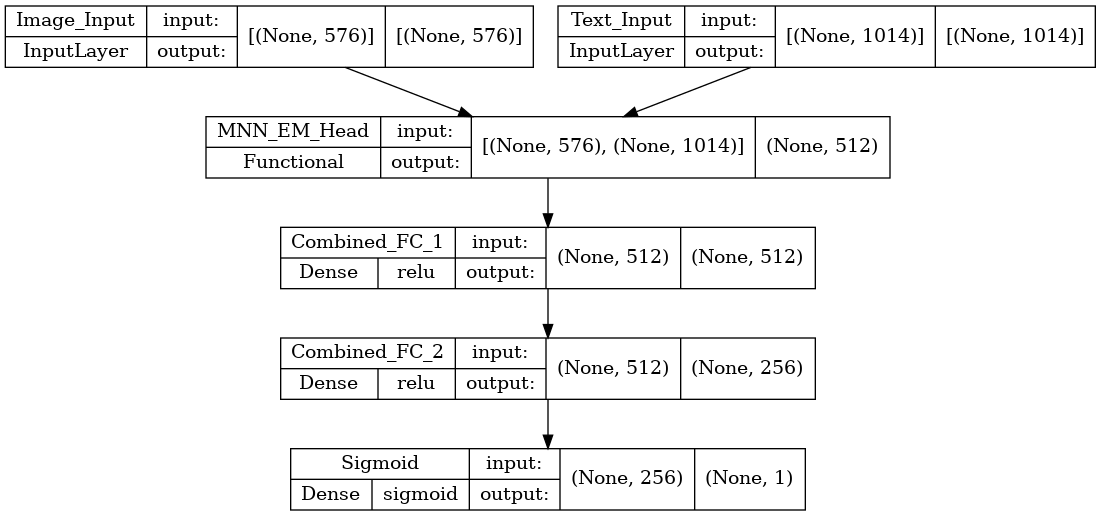

In [45]:
tf.keras.utils.plot_model(mnn_em.model, rankdir="TB", show_layer_activations=True, show_shapes=True)

In [33]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Multiply, BatchNormalization

In [34]:
# ext_mnn_em_tail = MNNEM(
#     img_input_size=img_model.layers[-1].output_shape[1],
#     txt_input_size=config["data"]["input_size"],
#     txt_weights=weights,
#     char_cnn_config=char_cnn_config,
#     img_fc_layers=config["ext_mnn_em"]["combined1_fc_layers"],
#     txt_fc_layers=config["ext_mnn_em"]["txt2_fc_layers"],
#     combined_fc_layers=config["ext_mnn_em"]["combined2_fc_layers"],
#     learning_rate=config["mnn_em"]["training"]["learning_rate"],
#     metrics=create_metrics(config["mnn_em"]["training"]["metrics"]))

In [35]:
# tf.keras.utils.plot_model(ext_mnn_em_tail.model, rankdir="TB", show_layer_activations=True, show_shapes=True)

# Callbacks

In [36]:
from utils.eval import create_callbacks

In [37]:
model_name = config["mnn_em"]["name"]
optimizer_name = config["mnn_em"]["training"]["optimizer"]
learning_rate = config["mnn_em"]["training"]["learning_rate"]

In [38]:
callbacks = create_callbacks(
    callbacks_list=config["mnn_em"]["training"]["callbacks"],
    model_name=model_name,
    img_model_name=img_model.name,
    optimizer_name=optimizer_name,
    learning_rate=learning_rate,
    cls=config["data"]["cls"]
    )

# Training

In [39]:
history = mnn_em.model.fit(
    x=[img_train, text_train],
    y=labels_train,
    epochs=config["mnn_em"]["training"]["epochs"],
    validation_split=config["mnn_em"]["training"]["validation_split"],
    batch_size=config["mnn_em"]["training"]["batch_size"], 
callbacks=callbacks)


Epoch 1/10
7176/7177 [============================>.] - ETA: 0s - loss: 1.0266 - recall: 0.8759 - precision: 0.6721 - binary_accuracy: 0.7237 - cosine_similarity: 0.5011

2023-05-25 16:10:38.811094: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7177/7177 [==============================] - 93s 12ms/step - loss: 1.0266 - recall: 0.8758 - precision: 0.6721 - binary_accuracy: 0.7237 - cosine_similarity: 0.5010 - val_loss: 0.4525 - val_recall: 0.9521 - val_precision: 0.7248 - val_binary_accuracy: 0.7977 - val_cosine_similarity: 0.4940
Epoch 2/10
7173/7177 [============================>.] - ETA: 0s - loss: 0.4326 - recall: 0.9436 - precision: 0.7407 - binary_accuracy: 0.8062 - cosine_similarity: 0.5011

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7177/7177 [==============================] - 87s 12ms/step - loss: 0.4325 - recall: 0.9436 - precision: 0.7407 - binary_accuracy: 0.8062 - cosine_similarity: 0.5010 - val_loss: 0.4007 - val_recall: 0.9300 - val_precision: 0.7652 - val_binary_accuracy: 0.8245 - val_cosine_similarity: 0.4940
Epoch 3/10
7174/7177 [============================>.] - ETA: 0s - loss: 0.3740 - recall: 0.9442 - precision: 0.7907 - binary_accuracy: 0.8468 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7177/7177 [==============================] - 87s 12ms/step - loss: 0.3741 - recall: 0.9442 - precision: 0.7906 - binary_accuracy: 0.8468 - cosine_similarity: 0.5010 - val_loss: 0.3689 - val_recall: 0.9099 - val_precision: 0.8039 - val_binary_accuracy: 0.8458 - val_cosine_similarity: 0.4940
Epoch 4/10
7177/7177 [==============================] - ETA: 0s - loss: 0.3397 - recall: 0.9555 - precision: 0.8092 - binary_accuracy: 0.8648 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7177/7177 [==============================] - 88s 12ms/step - loss: 0.3397 - recall: 0.9555 - precision: 0.8092 - binary_accuracy: 0.8648 - cosine_similarity: 0.5010 - val_loss: 0.3426 - val_recall: 0.9489 - val_precision: 0.8053 - val_binary_accuracy: 0.8614 - val_cosine_similarity: 0.4940
Epoch 5/10
7177/7177 [==============================] - 81s 11ms/step - loss: 0.3235 - recall: 0.9603 - precision: 0.8168 - binary_accuracy: 0.8722 - cosine_similarity: 0.5010 - val_loss: 0.3446 - val_recall: 0.9592 - val_precision: 0.8087 - val_binary_accuracy: 0.8678 - val_cosine_similarity: 0.4940
Epoch 6/10
7176/7177 [============================>.] - ETA: 0s - loss: 0.3080 - recall: 0.9656 - precision: 0.8230 - binary_accuracy: 0.8787 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7177/7177 [==============================] - 88s 12ms/step - loss: 0.3080 - recall: 0.9656 - precision: 0.8230 - binary_accuracy: 0.8787 - cosine_similarity: 0.5010 - val_loss: 0.3108 - val_recall: 0.9724 - val_precision: 0.8182 - val_binary_accuracy: 0.8796 - val_cosine_similarity: 0.4940
Epoch 7/10
7173/7177 [============================>.] - ETA: 0s - loss: 0.2948 - recall: 0.9667 - precision: 0.8292 - binary_accuracy: 0.8835 - cosine_similarity: 0.5010

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7177/7177 [==============================] - 89s 12ms/step - loss: 0.2948 - recall: 0.9667 - precision: 0.8292 - binary_accuracy: 0.8836 - cosine_similarity: 0.5010 - val_loss: 0.3061 - val_recall: 0.9722 - val_precision: 0.8227 - val_binary_accuracy: 0.8828 - val_cosine_similarity: 0.4939
Epoch 8/10
7177/7177 [==============================] - 82s 11ms/step - loss: 0.2805 - recall: 0.9693 - precision: 0.8367 - binary_accuracy: 0.8898 - cosine_similarity: 0.5010 - val_loss: 0.3115 - val_recall: 0.9511 - val_precision: 0.8276 - val_binary_accuracy: 0.8780 - val_cosine_similarity: 0.4940
Epoch 9/10
7173/7177 [============================>.] - ETA: 0s - loss: 0.2693 - recall: 0.9701 - precision: 0.8420 - binary_accuracy: 0.8938 - cosine_similarity: 0.5011

INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


INFO:tensorflow:Assets written to: ./runs/models/MNN_EM_ABO/cls_1/MobilenetV3small/Adam/lr_0.0001/assets


7177/7177 [==============================] - 88s 12ms/step - loss: 0.2693 - recall: 0.9701 - precision: 0.8420 - binary_accuracy: 0.8938 - cosine_similarity: 0.5010 - val_loss: 0.3013 - val_recall: 0.9556 - val_precision: 0.8376 - val_binary_accuracy: 0.8865 - val_cosine_similarity: 0.4940
Epoch 10/10
7177/7177 [==============================] - 82s 11ms/step - loss: 0.2545 - recall: 0.9705 - precision: 0.8504 - binary_accuracy: 0.8997 - cosine_similarity: 0.5010 - val_loss: 0.3080 - val_recall: 0.9537 - val_precision: 0.8402 - val_binary_accuracy: 0.8875 - val_cosine_similarity: 0.4939


# Evaluation

## Plot loss and metrics

In [40]:
from utils.eval import plot_metrics

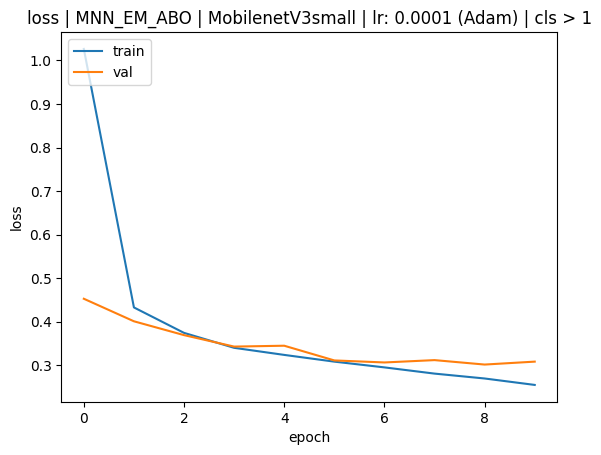

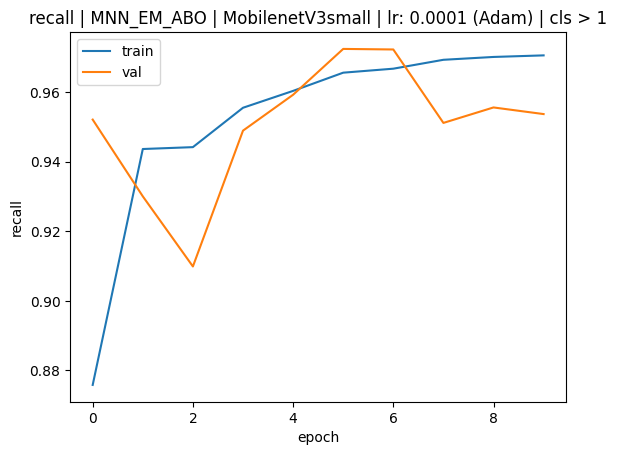

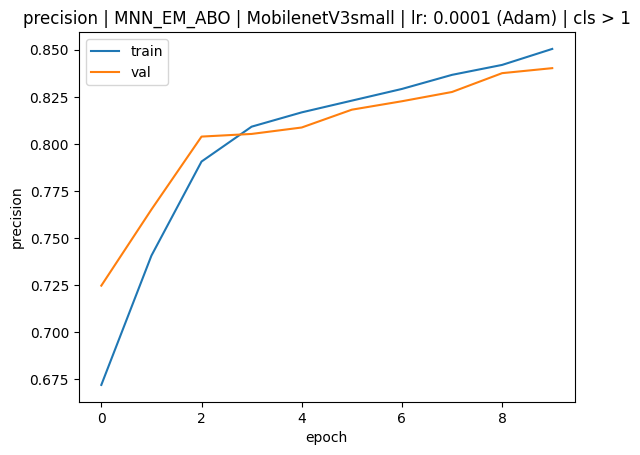

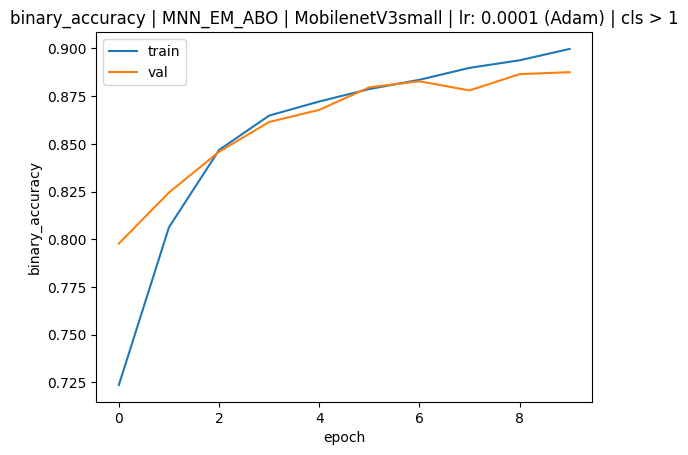

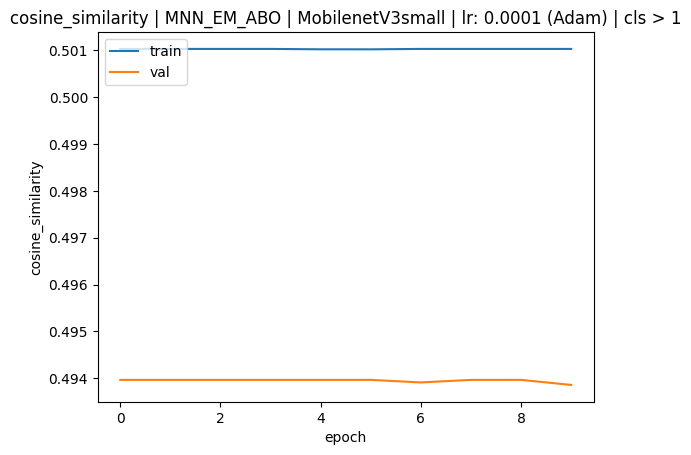

In [41]:
plot_metrics(history.history, config["mnn_em"]["training"]["metrics"], model_name, img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

## Evaluate model and save metrics

In [42]:
from utils.eval import evaluate

In [43]:
evaluate(mnn_em.model, img_test, text_test, labels_test, model_name, img_model.name, optimizer_name, learning_rate, config["data"]["cls"])

14177/14177 [==============================] - 66s 5ms/step - loss: 0.3170 - recall: 0.9512 - precision: 0.8441 - binary_accuracy: 0.8864 - cosine_similarity: 0.5061
